# *`Mini Project 3 – Twitter Sentimental Analysis Using NLP and Python`*

**Scenario:**

By analyzing text data, we can find meaningful insights from non-numeric data that can help us achieve our objective. With the help of NLP and its concepts, we can do it. Twitter is one of the biggest platforms that people use to write their messages, express their feelings about a particular topic, and share knowledge in the form of text. By analyzing text data, we can make good decisions for different use cases like judging the sentiment of the human tweets, and any product review/comments can tell us the performance of a product in the market.

NLP allows us to study and understand the colinearity of the data. So we can predict our objective.

**Objective:**

Use Python libraries such as Pandas for data operations, Seaborn and Matplotlib for data visualization and EDA tasks, NLTK to extract and analyze the information, Sklearn for model building and performance visualization, to predict our different categories of people’s mindsets.

**Dataset description:** The data contain information about many Tweets in the form of text and their types, as mentioned below.

* **Tweets:** Data is in the form of a sentence written by individuals.
* **category:**
  1. Numeric (0: Neutral, -1: Negative, 1: Positive) (It is our dependent variable)

In [25]:
# Make necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
# Create an Early Stopping callback
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               mode = 'auto')

The following tasks are to be performed:
* Read the Data from the Given excel file.
* Change our dependent variable to categorical. ( 0 to “Neutral,” -1 to “Negative”, 1 to “Positive”)
* Do Missing value analysis and drop all null/missing values
* Do text cleaning. (remove every symbol except alphanumeric, transform all words to lower case, and remove punctuation and stopwords )
* Create a new column and find the length of each sentence (how many words they contain)
* Split data into dependent(X) and independent(y) dataframe
* Do operations on text data

> Hints:
* Do one-hot encoding for each sentence (use TensorFlow)
* Add padding from the front side (use Tensorflow)
* Build an LSTM model and compile it (describe features, input length, vocabulary size, information drop-out layer, activation function for output, )
* Do dummy variable creation for the dependent variable
* split the data into tests and train

* Train new model
* Normalize the prediction as same as the original data(prediction might be in decimal, so whoever is nearest to 1 is predicted as yes and set other as 0)
* Measure performance metrics and accuracy
* print Classification report

## Get the data

In [2]:
!wget https://raw.githubusercontent.com/krutika-shimpi/Edureka_Internship_Assigments_solved/main/Mini_Project_3_Twitter_Sentiment_Analysis/Dataset/Twitter_Data.csv

--2024-03-18 09:19:41--  https://raw.githubusercontent.com/krutika-shimpi/Edureka_Internship_Assigments_solved/main/Mini_Project_3_Twitter_Sentiment_Analysis/Dataset/Twitter_Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20895533 (20M) [text/plain]
Saving to: ‘Twitter_Data.csv’

Twitter_Data.csv    100%[===================>]  19.93M  --.-KB/s    in 0.1s    

2024-03-18 09:19:42 (194 MB/s) - ‘Twitter_Data.csv’ saved [20895533/20895533]



In [3]:
# Read the data into pandas dataframe
twitter_data = pd.read_csv('Twitter_Data.csv')
twitter_data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
# Change our dependent variable to categorical. ( 0 to “Neutral,” -1 to “Negative”, 1 to “Positive”)
category_mapping = {0: "Neutral", -1: "Negative", 1: "Positive"}

# Use the map function to map numerical values to categories
twitter_data['category'] = twitter_data['category'].map(category_mapping)

twitter_data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


In [5]:
twitter_data.shape

(162980, 2)

## Visualize some random sentences

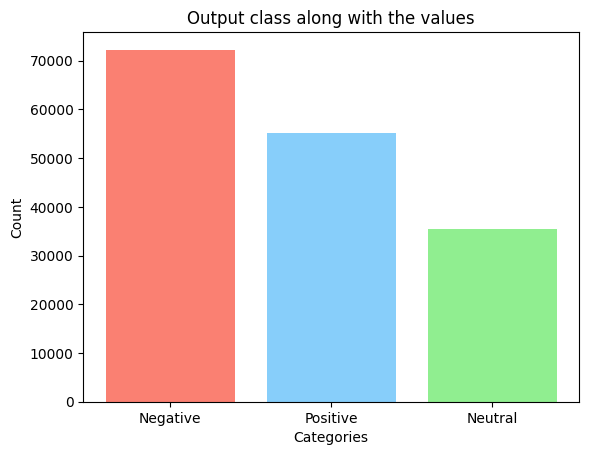

In [6]:
# Inspect the output column and check how many values are present for each class
plt.bar(['Negative', 'Positive', 'Neutral'], twitter_data['category'].value_counts(), color = ['salmon', 'lightskyblue', 'lightgreen'])
plt.title('Output class along with the values')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [7]:
# Print a random sentence and its assigned class
print('\nSample sentences along with labels:\n')
for i in range(5):
  random_index = np.random.randint(0, twitter_data.shape[0])
  text = twitter_data['clean_text'][random_index]
  label = twitter_data['category'][random_index]
  print(f'\nText {i + 1}:\n{text}\n\nLabel {i + 1}: {label}\n')


Sample sentences along with labels:


Text 1:
modi cell dalle bahut his tum logon bewakoofi time for lies over and time kick you guys out

Label 1: Neutral


Text 2:
said very correct when said who are against modi are against india 

Label 2: Positive


Text 3:
modi joker not chowkidar

Label 3: Neutral


Text 4:
factual analysis soch and dhruv rathi performance modi government last yrs according different indicators those are exact marks that given after completely analysis india needs this type journalism 

Label 4: Positive


Text 5:
please play the video where shri modi said will top lacs each person spoke sperson and congress speakers 

Label 5: Positive



In [8]:
# Perform Missing value analysis and drop all null/missing values
twitter_data.isna().sum()
twitter_data.dropna(inplace=True)
twitter_data.shape

(162969, 2)

## Prepare the data/ Preprocessing the data

In [9]:
# Do text cleaning. (remove every symbol except alphanumeric, transform all words to lower case, and remove punctuation and stopwords )
def clean_text(text):

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stopwords_list = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stopwords_list]

    # Join the tokens back into a string
    clean_text = ' '.join(tokens)
    return clean_text

# Example sentence to check how our function works
sample_text = "Hello! This is an example text with symbols, punctuation, and stopwords."
cleaned_text = clean_text(sample_text)
print("Original text:", sample_text)
print("\nCleaned text:", cleaned_text)

Original text: Hello! This is an example text with symbols, punctuation, and stopwords.

Cleaned text: Hello example text symbols punctuation stopwords


In [10]:
# Lets remove the punctuations and stopwords from our data as well
twitter_data['clean_text'] = twitter_data['clean_text'].apply(clean_text)

In [11]:
# Create a new column and find the length of each sentence (how many words they contain)
twitter_data['sentence_length'] = twitter_data['clean_text'].apply(lambda x: len(x.split()))
twitter_data.head()

,clean_text,category,sentence_length
0,modi promised “ minimum government maximum gov...,Negative,23
1,talk nonsense continue drama vote modi,Neutral,6
2,say vote modi welcome bjp told rahul main camp...,Positive,13
3,asking supporters prefix chowkidar names modi ...,Positive,19
4,answer among powerful world leader today trump...,Positive,10


In [12]:
# Vizualize the average length of the sentences in the data
avg_len = sum(twitter_data['sentence_length'])/len(twitter_data['sentence_length'])
print(f'Avg length of sentences: {avg_len}')
print(f"Max length : {max(twitter_data['sentence_length'])}")
print(f"Min length :{min(twitter_data['sentence_length'])}")

Avg length of sentences: 14.514459805239033
Max length : 43
Min length :0


In [13]:
# Split data into dependent(X) and independent(y) dataframe
X = twitter_data.drop('category', axis = 1)
y = twitter_data['category']

# Create dummy variables for target variable
labels = pd.get_dummies(y)

# Perform train_test_split
X_train, X_test, y_train, y_test = train_test_split(X['clean_text'].values, labels, test_size = 0.2, random_state = 42)

len(X_train), len(y_train), len(X_test), len(y_test)

(130375, 130375, 32594, 32594)

# Do operations on text data
Hints:

* Do one-hot encoding for each sentence (use TensorFlow)
* Add padding from the front side (use Tensorflow)
* Build an LSTM model and compile it (describe features, input length vocabulary size, information drop-out layer, activation function for output, )
* Do dummy variable creation for the dependent variable
* split the data into tests and train

In [14]:
# Set the maximum sequence length
max_sequence_length = 100

# Create a TextVectorization layer with padding from the front side
vectorizer = tf.keras.layers.TextVectorization(output_mode='binary',
                                                max_tokens=10000,
                                                pad_to_max_tokens=True)

# Adapt the TextVectorization layer to the text data
vectorizer.adapt(X_train)

In [15]:
# Get the unique words in the vocabulary
words_in_vocab = vectorizer.get_vocabulary() # Get all of the unique words in our training data found by the TextVectorizer
top_5_words = words_in_vocab[:5] # Get the most common words
bottom_5_words = words_in_vocab[-5:] # Get the least common words
print(f'Number of words in Vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in Vocab: 10000
5 most common words: ['[UNK]', 'modi', 'india', '’', 'bjp']
5 least common words: ['shishupal', 'sentences', 'semen', 'seena', 'secularists']


## Building the Model

In [24]:
# Create an efficient and performant data pipeline
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch and prefetch the data
train_data = train_data.shuffle(len(X_train)).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
# Create an Embedding Layer
from tensorflow.keras.layers import Embedding

embedding  = Embedding(input_dim = len(words_in_vocab),
                       output_dim = 128,
                       input_length = max_sequence_length) # How long each output of the text would be

In [23]:
# Build an LSTM model and compile it (describe features, input length vocabulary size, information drop-out layer, activation function for output, )
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

inputs = Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = embedding(x)
x = LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(x)
x = LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

# Combine the inputs and outputs of the
lstm_model = tf.keras.Model(inputs, outputs, name = 'LSTM_1')

# Compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [18]:
lstm_model.summary()

Model: "LSTM_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 10000)             0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 10000, 128)        1280000   
                                                                 
 lstm (LSTM)                 (None, 10000, 64)         49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                            

In [ ]:
# Fit the model
lstm_model_history = lstm_model.fit(train_data,
                                    epochs = 100,
                                    steps_per_epoch = len(train_data),
                                    validation_data = int(len(test_data) * 0.15),
                                    callbacks = [early_stopping])

Epoch 1/100
   5/4075 [..............................] - ETA: 92:19:11 - loss: 1.0751 - accuracy: 0.4250